In [1]:
# 1. import dataset
import pandas as pd
file_path = "../datasets/amazon_user_reviews_regular_ML_simplified.parquet"
df = pd.read_parquet(file_path)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16949 entries, 0 to 16948
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   rating                 16949 non-null  float64
 1   exclamation_count      16949 non-null  int64  
 2   question_count         16949 non-null  int64  
 3   word_count             16949 non-null  int64  
 4   char_count             16949 non-null  int64  
 5   all_caps_words         16949 non-null  int64  
 6   uppercase_ratio        16949 non-null  float64
 7   total_punctuation      16949 non-null  int64  
 8   avg_word_length        16949 non-null  float64
 9   helpful_vote           16949 non-null  int64  
 10  int_verified_purchase  16949 non-null  int64  
 11  hour                   16949 non-null  int32  
 12  month                  16949 non-null  int32  
 13  season                 16949 non-null  int64  
dtypes: float64(3), int32(2), int64(9)
memory usage: 1.7 MB

In [2]:
# based on rsult of feature selection:
## keep one from word_count, char_count, total_punctuatuation, (*verified_purchase)
## keep one from season and month

# choose word_count, verified_purchase, month
features = ['exclamation_count', 'question_count', 'word_count',
       'all_caps_words', 'uppercase_ratio',
       'avg_word_length', 'helpful_vote', 'int_verified_purchase', 'hour',
       'month']

In [3]:
# Random Forest deployment
import numpy as np
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

y = df["rating"]
X = df[features]

# 1. data preprocessing
# downsampling
print(f"Original Class Distribution: {Counter(y)}")
rus = RandomUnderSampler(sampling_strategy='majority')
X_resampled_down, y_resampled_down = rus.fit_resample(X, y)
print(f"After Upsampling: {Counter(y_resampled_down)}")

# Standarlization
scaler = StandardScaler()
scaler.fit(X_resampled_down)
X_scaled = scaler.transform(X_resampled_down)

# PCA
pca = PCA(n_components="mle")
X_scaled_pca = pca.fit_transform(X_scaled)

# data split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_pca, y_resampled_down, test_size=0.3, random_state=42)

Original Class Distribution: Counter({5.0: 11212, 4.0: 2750, 3.0: 1268, 1.0: 1064, 2.0: 655})
After Upsampling: Counter({4.0: 2750, 3.0: 1268, 1.0: 1064, 2.0: 655, 5.0: 655})


MODEL EVALUATION METRICS
Accuracy:  0.3973
Precision: 0.3168
Recall:    0.3973
F1-Score:  0.3327

CLASSIFICATION REPORT
              precision    recall  f1-score   support

         1.0       0.25      0.17      0.21       331
         2.0       0.08      0.02      0.03       208
         3.0       0.22      0.15      0.18       355
         4.0       0.47      0.77      0.59       825
         5.0       0.19      0.06      0.09       199

    accuracy                           0.40      1918
   macro avg       0.24      0.23      0.22      1918
weighted avg       0.32      0.40      0.33      1918



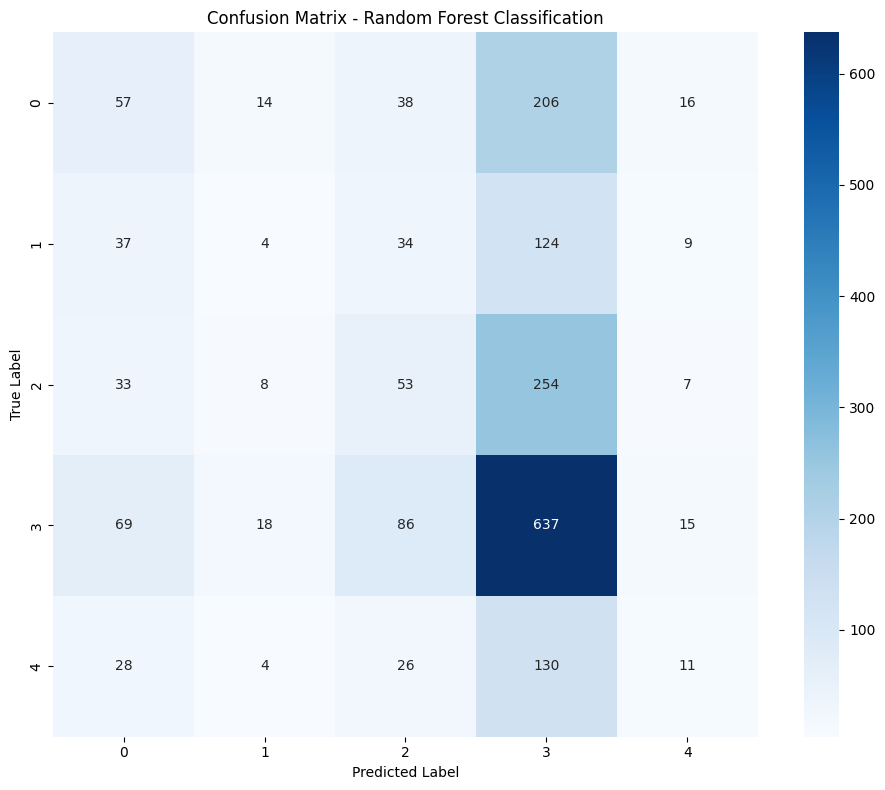

In [4]:
# 2. model deployment
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# 3. predict
y_pred = rf_classifier.predict(X_test)

# 4. evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("=" * 50)
print("MODEL EVALUATION METRICS")
print("=" * 50)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print("\n" + "=" * 50)
print("CLASSIFICATION REPORT")
print("=" * 50)
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True)
plt.title('Confusion Matrix - Random Forest Classification')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()